In [1]:
import sys
sys.path.append('/afs/ee.cooper.edu/user/t/a/tam8/documents/ml_misc/semi_supervised/')
import coreg
reload(coreg)
sys.path.append('/afs/ee.cooper.edu/user/t/a/tam8/documents/ml_misc/ordinal/')
import simple
reload(simple)

from transformers import *
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union

import pandas as pd
import numpy as np
from sklearn import preprocessing
import xgboost as xgb

import metrics
reload(metrics)
from sklearn.cross_validation import StratifiedKFold

from sklearn.base import clone

from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, ExtraTreesRegressor

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from time import time

In [2]:
# Load Data
import cPickle as pickle
train_pd  = pd.read_pickle('saved/train_pd_enc.p')
test_pd  = pd.read_pickle('saved/test_pd_enc.p')
labels = pd.read_pickle('saved/labels.p')
test_ind = pickle.load(open('saved/test_ind.p'))

train = np.array(train_pd)
test = np.array(test_pd)

In [3]:
X_train = train.astype(float)
X_test = test.astype(float)
y_train = np.array(labels)


pipe = make_pipeline(
    make_union(
        IdentityTformer(),
#         make_pipeline(AddTformer(1), BoxCoxTformer()),
#         AnscombeTformer(),
    ),
    StandardScaler(),
)
pipe.fit(np.r_[X_train, X_test])


X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)
# y_train = StandardScaler().fit_transform(np.log(y_train+1))

# small_n = 5000
# X_train = X_train[:small_n,:]
# y_train = y_train[:small_n]

print y_train.shape
print X_train.shape
print X_test.shape
print len(np.unique(y_train))

(50999,)
(50999, 111)
(51000, 111)
50


# Keras

In [41]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adadelta, Adagrad, Adam

model = Sequential()

model.add(Dense(111, 256))
model.add(Dropout(0.2))
model.add(Activation('relu'))
# model.add(BatchNormalization(256))
model.add(Dropout(0.6))
model.add(Dense(256, 256))
model.add(Activation('relu'))
# model.add(BatchNormalization(256))
model.add(Dropout(0.6))
model.add(Dense(256, 256))
model.add(Activation('relu'))
# model.add(BatchNormalization(256))
model.add(Dropout(0.6))
model.add(Dense(256, 1))

# model.add(Dense(32, 256))
# model.add(Activation('linear'))
# model.add(Dense(256, 512))
# model.add(Activation('linear'))
# model.add(Dense(512, 256))
# model.add(Activation('linear'))
# model.add(Dense(256, 1))

loss_type = 'mean_squared_error'
# opt = Adadelta(lr=1.0, rho=0.95, epsilon=1e-6)
# opt = Adadelta(lr=0.8, rho=0.90, epsilon=1e-6)
opt = Adagrad(lr=0.01, epsilon=1e-6)

# loss_type = 'mean_absolute_error'
# model.compile(loss=loss_type, optimizer='rmsprop')

# model.fit(X_train, y_train, nb_epoch=20, batch_size=1024)
# score = model.evaluate(X_test, y_test, batch_size=1024)

model.compile(loss=loss_type, optimizer=opt)
model.save_weights('saved/nn_weights', overwrite=True)

In [42]:
# clf = simple.SimpleOrdinalClassifier(nn)

# clf = KerasClassifier(model=model, optimizer='rmsprop', loss=loss_type)

losses = []
from keras.callbacks import Callback
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        pass
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('val_loss'))
# clf = ElasticNet()

scores = []
scores_base = []
n_reps = 1
k = 3
for reps in range(n_reps):
    skf = StratifiedKFold(y_train, n_folds=k,
                          shuffle=True,
                          random_state=np.random.randint(0,100))
    for ii, (train, valid) in enumerate(skf):
        model.load_weights('saved/nn_weights')
        
        
        history = LossHistory()   # for keras
        print 'Fold %d' % ii,
        X_train_k = X_train[train]
        X_valid_k = X_train[valid]
        y_train_k = y_train[train]
        y_valid_k = y_train[valid]
        
        tic = time()
#         clf.fit(X_train_k, y_train_k)
        
#         clf.fit(X_train_k, y_train_k, batch_size=16384, nb_epoch=200)
    
        model.fit(X_train_k, y_train_k, 
                  nb_epoch=400, batch_size=16384,
                  validation_data=(X_valid_k, y_valid_k),
                  callbacks=[history],
                  verbose=0)
        
        toc = time() - tic
        print 'Train time: %2.3f s\t' % toc, 

#         valid_preds = clf.predict(X_valid_k)
#         valid_preds = clf.predict_proba(X_valid_k, batch_size=16384).flatten()
        valid_preds = model.predict_proba(X_valid_k, batch_size=16384, verbose=0).flatten()
        
#         score = metrics.gini(y_valid_k, valid_preds)
        score = metrics.normalized_gini(y_valid_k, valid_preds)
        
        print 'Score %1.5f' % score
        scores.append(score)
        
        losses.append(history.losses)
        
print "done"
print np.array(scores).mean()

Fold 0 Train time: 29.807 s	Score 0.34635
Fold 1 Train time: 29.850 s	Score 0.33943
Fold 2 Train time: 29.818 s	Score 0.33459
done
0.340120756639


(14, 16)

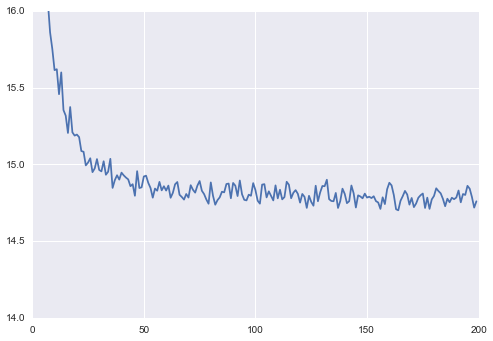

In [43]:
plt.plot(np.mean(losses, axis=0))
plt.ylim([14, 16])

In [21]:
nn.get_params(deep=False)

{'loss': 'mean_absolute_error',
 'model': <keras.models.Sequential at 0x7f72ef18dbd0>,
 'optimizer': 'rmsprop'}

# Predict Test Set

In [60]:
model.compile(loss=loss_type, optimizer='rmsprop')
model.fit(X_train, y_train, 
          nb_epoch=10, batch_size=16384,
          callbacks=[history],
          verbose=0)

preds = model.predict_proba(X_test, batch_size=16384, verbose=0).flatten()

In [62]:
print preds.shape
print X_test.shape

(51000,)
(51000, 111)


# Generate submission

In [63]:
preds = pd.DataFrame({"Id": test_ind, "Hazard": preds})
preds = preds.set_index('Id')
preds.to_csv('submissions/keras_benchmark.csv')